### Example of Automated Civilian Fatal Encounter Modeler (including analysis)


Using Facebook's Open Source Prophet API

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objs as go
plt.rcParams['figure.figsize'] = 20, 12
import itertools 
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric as pcvm
from scipy.special import inv_boxcox1p, boxcox1p
from scipy.stats import normaltest
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta
from urllib.parse import quote
import time
import holidays
import random

Import, Transform, Creating, and Reading Datasets as a Time Series

In [2]:
# Importing Dataset
gsheetid = r'1dKmaV_JiWcG8XBoRgP8b4e9Eopkpgt7FL7nyspvzAsE'
sheet_name = quote('Form Responses', safe='')
gsheet_url = r"https://docs.google.com/spreadsheets/d/{}/gviz/tq?tqx=out:csv&sheet={}".format(gsheetid, sheet_name)
df = pd.read_csv(gsheet_url)

C:\Users\latee\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,20,21,22,23,24,25,26,37,39,40,41,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Transforming Dataset
    #  Casting columns in lowercase
df.columns = map(lambda x: x.lower(), df.columns)

    # Casting new column names
df = df.rename(columns={"subject's race":"race", 'location of death (city)' : 'city',
                        'location of death (county)' : 'county', 'location of death (zip code)':'zipcode',
                        "date of injury resulting in death (month/day/year)":"date"})

    # Filling in missing data points in observations with values that doesn't obscure data
df = df.fillna(value={'race':'unspecified', 'location of death (city)':'unspecified',
                      'location of death (county)':'unspecified'})

In [4]:
# Creating National Time Series Dataframe 
ld = list(df.date)
ld1 = pd.to_datetime(ld)
ld2 = pd.Series(ld1.to_period('d'))
ts = ld2.value_counts().sort_index().reset_index()
ts.columns = ['date', 'count']
ts.date = ts.date.dt.strftime('%m-%d-%Y')
ts.index = pd.to_datetime(ts.date)
tss = ts.drop('date', axis=1)
# this had to be a added to drop the invalid date they have in their google sheet as a spacer
tsss = tss[:-1]
all_dates = pd.date_range(start='2000/01/01', end=tsss.index.max(), freq='D')
national = tsss.reindex(all_dates, fill_value=0)

In [5]:
print('-'*60)
print('*** Head of the National dataframe ***')
print('-'*60)
print(national.head())
print('-'*60)
print('*** Tail of the National dataframe ***')
print('-'*60)
print(national.tail())

------------------------------------------------------------
*** Head of the National dataframe ***
------------------------------------------------------------
            count
2000-01-01      4
2000-01-02      6
2000-01-03      3
2000-01-04      0
2000-01-05      6
------------------------------------------------------------
*** Tail of the National dataframe ***
------------------------------------------------------------
            count
2021-02-04      8
2021-02-05      5
2021-02-06      7
2021-02-07      6
2021-02-08      3


In [6]:
# Function that takes a Dataframe and a column header to create a new dataframe based on column headers unique value counts
    # Remember the global variable all_dates = pd.date_range(start='2000/01/01', end="last date in national dataframe", freq='D')
def output_ts_dict(df, column_header):
    # Check if column header is in df
        # If so, append every unique value of that Series to the list "unique_values"
    unique_values = []
    if column_header in df:
        unique_values.append(df[column_header].unique())
    else:
        return print('Column header not found')
    
    # Create a DataFrame of Series's containing a boolean mask for each item in unique_values
    masks = pd.DataFrame()
    for items in unique_values:
        for item in items:
            masks[item] = df[column_header] == item
    
    # Create a Dictionary of DataFrames one for each Series in the DataFrame masks
    dict_dfs = {}
    for columns in masks.columns:
        dict_dfs[columns] = df[masks[columns]]
    
    # Create a Dicitonary that stores the info needed for the TimeSeries-DataFrame
    dict_dfs001 = {}
    for item in dict_dfs.keys():
        dict_dfs001[item] = dict_dfs[item]['date']
    
    # Creating a Dictionary to hold TimeSeries-DataFrames and Performing Transformations that make them easy to use out of the Function
    dict_dfs002 = {}
    for count, key in enumerate(dict_dfs001):
        lister = list(dict_dfs001[key])
        date_lister = pd.to_datetime(lister)
        series_lister = pd.Series(date_lister.to_period('d'))
        time_series = series_lister.value_counts().sort_index().reset_index()
        time_series.columns = ['date', 'count']
        time_series.date = time_series.date.dt.strftime('%m-%d-%Y')
        time_series.index = pd.to_datetime(time_series.date)
        key_add = time_series.drop('date', axis=1)
        dict_dfs002[key] = key_add
        dict_dfs002[key] = dict_dfs002[key].reindex(all_dates, fill_value=0)
    return dict_dfs002

In [7]:
# Creating a dictionary of time series dataframes (one state per dataframe) 
states = output_ts_dict(df, 'state')

In [8]:
print('-'*60)
print('*** Head of dataframe for California ***')
print('-'*60)
print(states['CA'].head())
print('-'*60)
print('*** Tail of dataframe for California ***')
print('-'*60)
print(states['CA'].tail())

------------------------------------------------------------
*** Head of dataframe for California ***
------------------------------------------------------------
            count
2000-01-01      1
2000-01-02      1
2000-01-03      0
2000-01-04      0
2000-01-05      0
------------------------------------------------------------
*** Tail of dataframe for California ***
------------------------------------------------------------
            count
2021-02-04      1
2021-02-05      0
2021-02-06      1
2021-02-07      1
2021-02-08      0


In [9]:
national.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7710 entries, 2000-01-01 to 2021-02-08
Freq: D
Data columns (total 1 columns):
count    7710 non-null int64
dtypes: int64(1)
memory usage: 120.5 KB


In [10]:
states['CA'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7710 entries, 2000-01-01 to 2021-02-08
Freq: D
Data columns (total 1 columns):
count    7710 non-null int64
dtypes: int64(1)
memory usage: 120.5 KB


### Exploratory Data Analysis - Presentation

In [11]:
# Function to create dataframe that breaks up the different aspects of dates of fatal encounters out into columns
def date_features(df, label=None):
    df = df.copy()
    
    df['date'] = df.index
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime("%A")
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    return X

X, y = date_features(national, label='count')
df_national_time = pd.concat([X, y], axis=1)
df_national_time.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,count
2000-01-01,Saturday,1,January,2000,1,1,52,4
2000-01-02,Sunday,1,January,2000,2,2,52,6
2000-01-03,Monday,1,January,2000,3,3,1,3
2000-01-04,Tuesday,1,January,2000,4,4,1,0
2000-01-05,Wednesday,1,January,2000,5,5,1,6


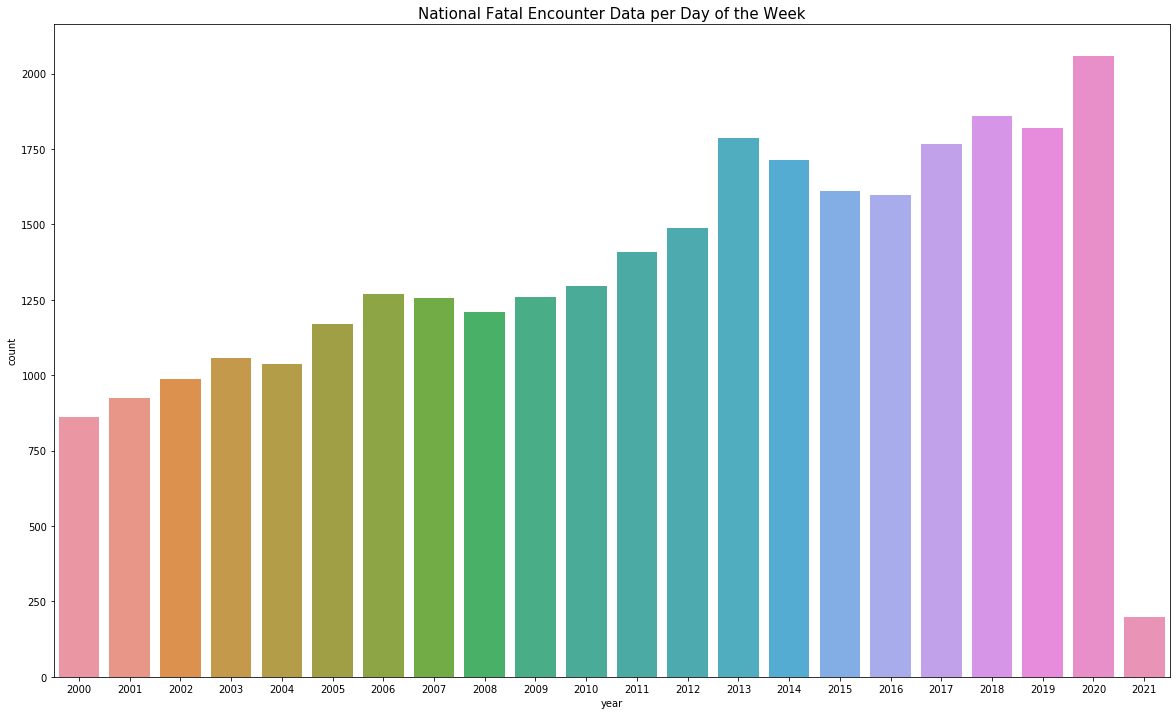

In [12]:
fig, ax = plt.subplots(figsize=(20,12))
yearaggregated = pd.DataFrame(df_national_time.groupby("year")["count"].sum()).reset_index()
a = sns.barplot(data=yearaggregated, x="year", y="count")
a.set_title("National Fatal Encounter Data per Day of the Week", fontsize=15)
plt.show()

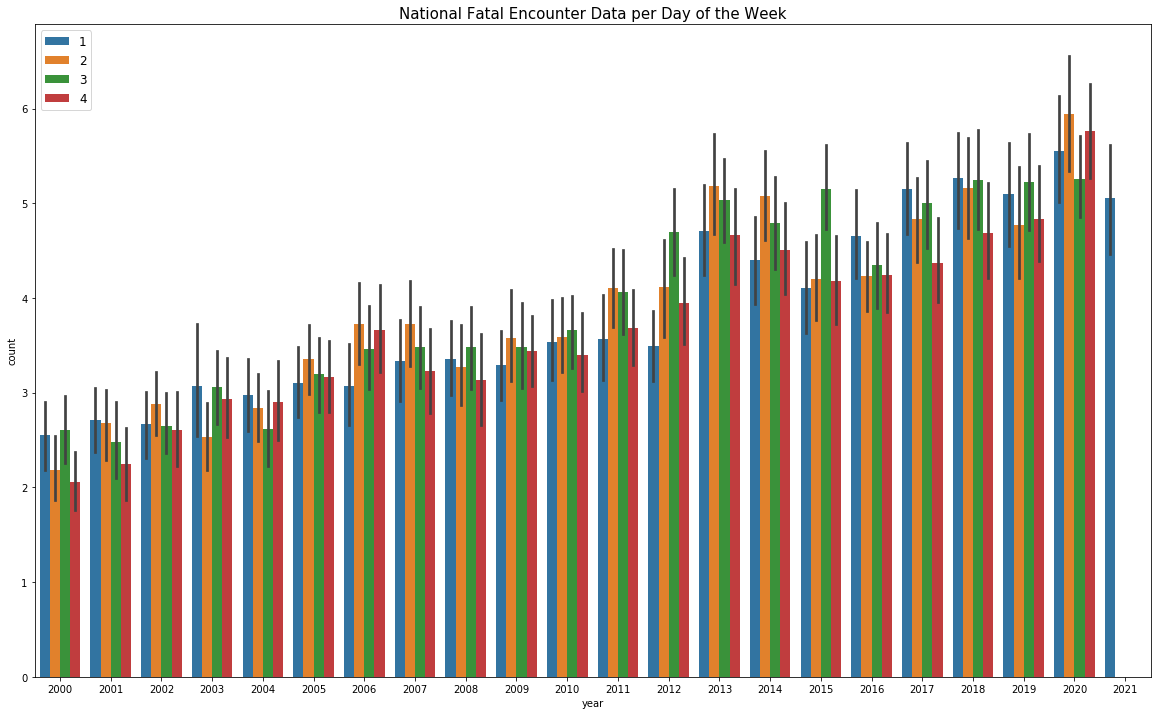

In [13]:
fig, ax = plt.subplots(figsize=(20,12))
a = sns.barplot(x= "year", y= "count", hue = 'quarter', data = df_national_time)
a.set_title("National Fatal Encounter Data per Day of the Week", fontsize=15)
plt.legend(loc='best', prop={'size': 12})
plt.show()

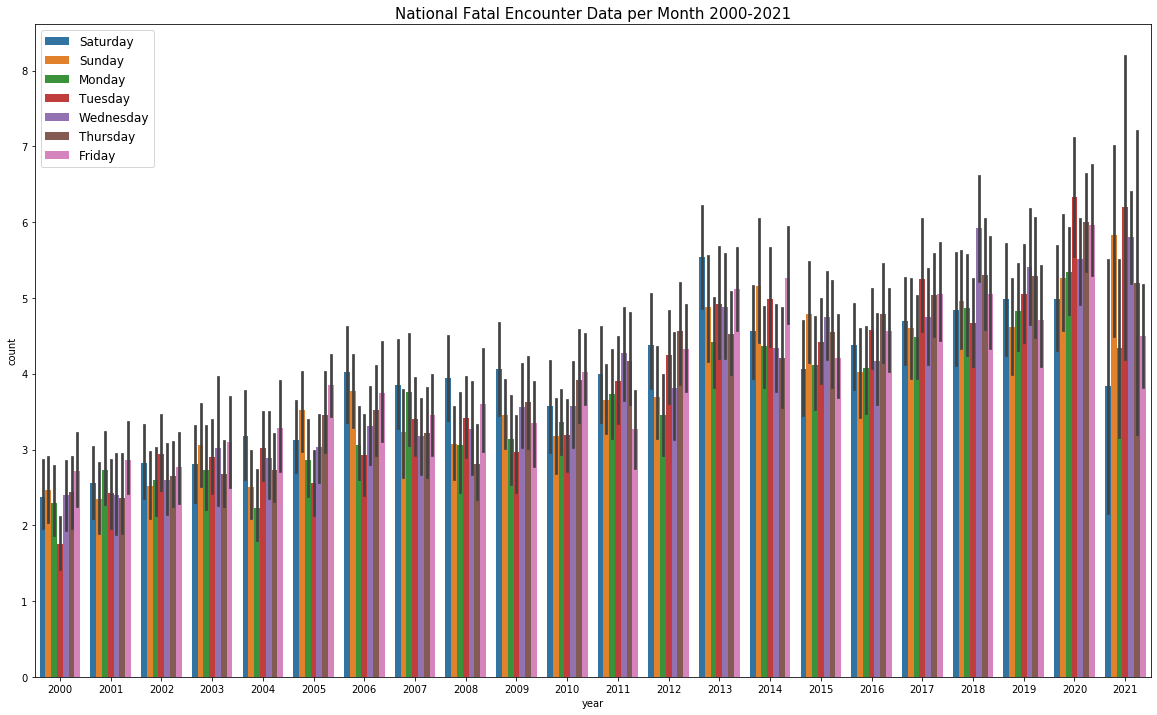

In [14]:
fig, ax = plt.subplots(figsize=(20,12))
a = sns.barplot(x= "year", y= "count", hue = 'dayofweek', data = df_national_time)
a.set_title("National Fatal Encounter Data per Month 2000-2021", fontsize=15)
plt.legend(loc='best', prop={'size': 12})
plt.show()

### Preprocessing - Presentation

In [15]:
def test_stationarity(timeseries, title):
    
    # Determining Rolling Statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    rolvar = timeseries.rolling(window=365).var()
    
    # Plot Rolling Statistics
    fig, ax = plt.subplots(figsize=(20,12))
    a = plt.plot(timeseries, color='blue', label='Original')
    a = plt.plot(rolmean, color='red', label='Rolling Mean')
    a = plt.plot(rolstd, color='black', label='Rolling STD')
    a = plt.plot(rolvar, color='orange', label='Rolling Variance')
    a = plt.legend(loc='best')
    ax.set_title(title, fontsize=15)
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[:4], index=['Test Statistic', 'p-value', '#Lags Used',
                                            'Number of Oberservations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Add to the Product - Scientific Mode

Test Statistic of National Before Transform: [918.81440955]
p_value of National Before Transform: [3.03379352e-200]

Test Statistic of National After Transform: [7.08190769]
p_value of National After Transform: [0.02898567]



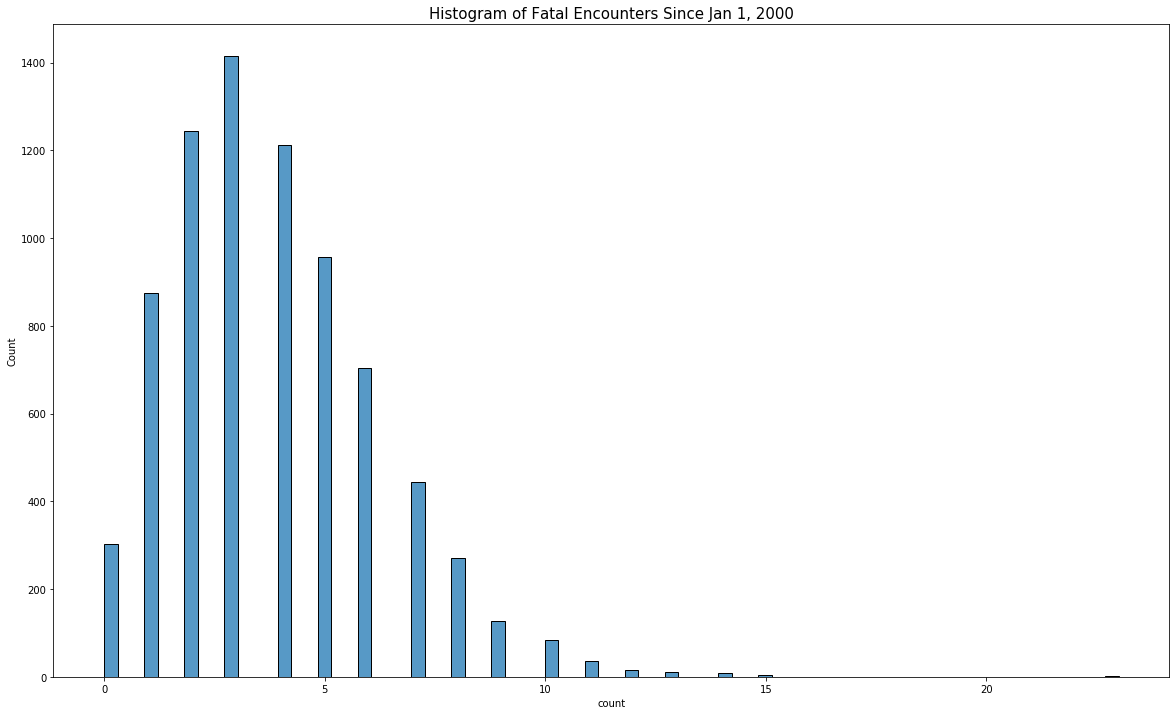

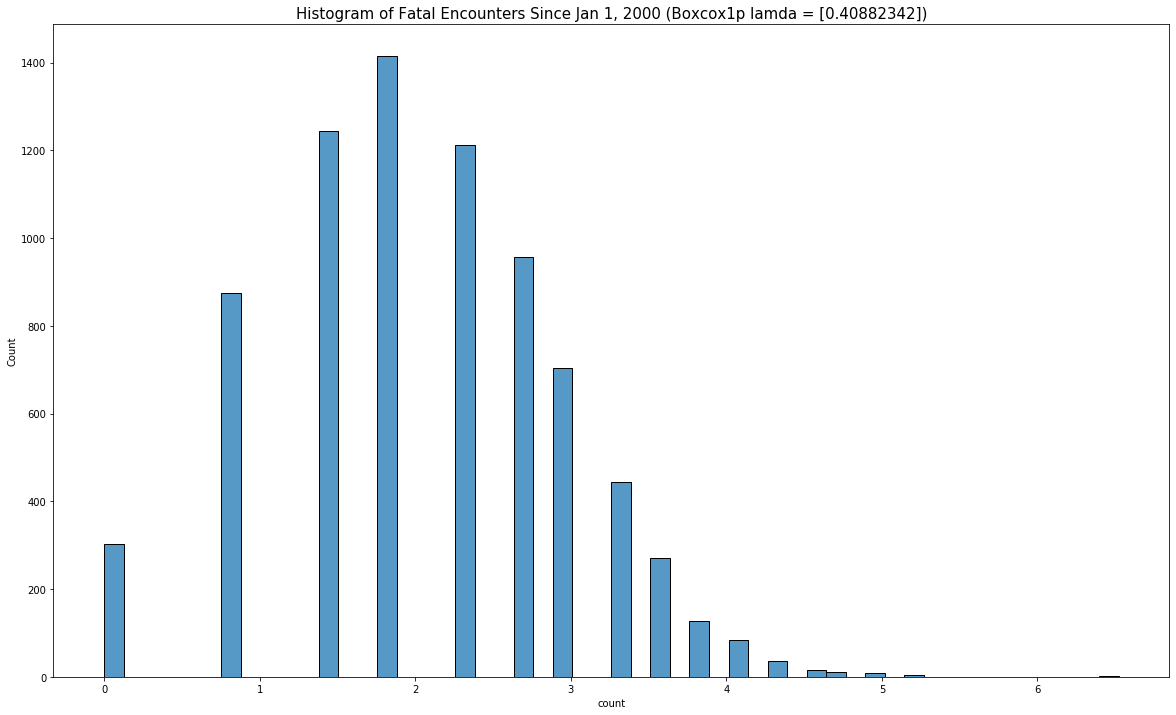

In [16]:
# Our dataset meets the requirements of stationarity, but misses the mark of normalcy

# method 'yeo-johnson' is selected bcuz the data contains non-positive numbers i.e 0
pt = PowerTransformer(method='yeo-johnson')
pt.fit(national)
lam = pt.lambdas_

box1p_national = boxcox1p(national, lam)

fig, ax = plt.subplots(figsize=(20,12))
a = sns.histplot(data=national, x="count")
a.set_title("Histogram of Fatal Encounters Since Jan 1, 2000", fontsize=15)

stat, p_ = normaltest(national)

print('Test Statistic of National Before Transform:', stat)
print('p_value of National Before Transform:', p_)
print()

fig, ax = plt.subplots(figsize=(20,12))
a = sns.histplot(data=box1p_national, x="count")
a.set_title("Histogram of Fatal Encounters Since Jan 1, 2000 (Boxcox1p lambda = {})".format(lam), fontsize=15)

stat, p_ = normaltest(box1p_national)

print('Test Statistic of National After Transform:', stat)
print('p_value of National After Transform:', p_)
print()

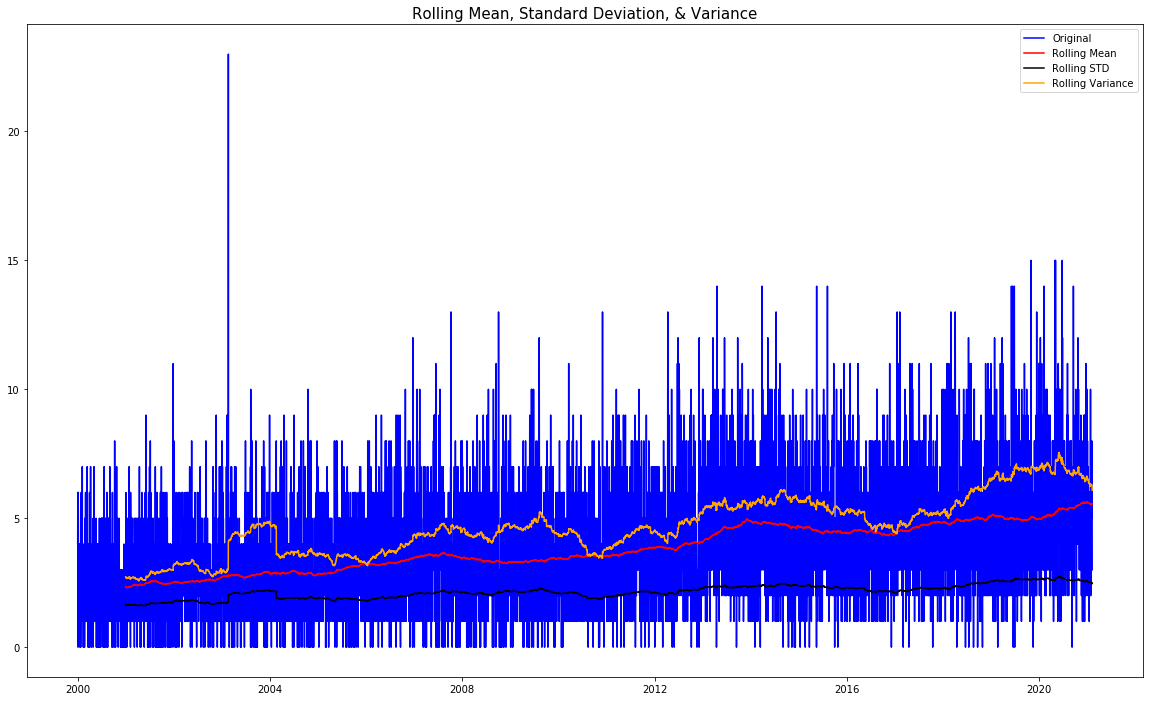

Results of Dickey-Fuller Test:
Test Statistic                     -5.115647
p-value                             0.000013
#Lags Used                         36.000000
Number of Oberservations Used    7673.000000
Critical Value (1%)                -3.431203
Critical Value (5%)                -2.861917
Critical Value (10%)               -2.566971
dtype: float64


,count
count,7710.000000
mean,3.843320
std,2.347343
min,0.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,23.000000


In [33]:
test_stationarity(national, 'Rolling Mean, Standard Deviation, & Variance of Orginal')
national.describe()

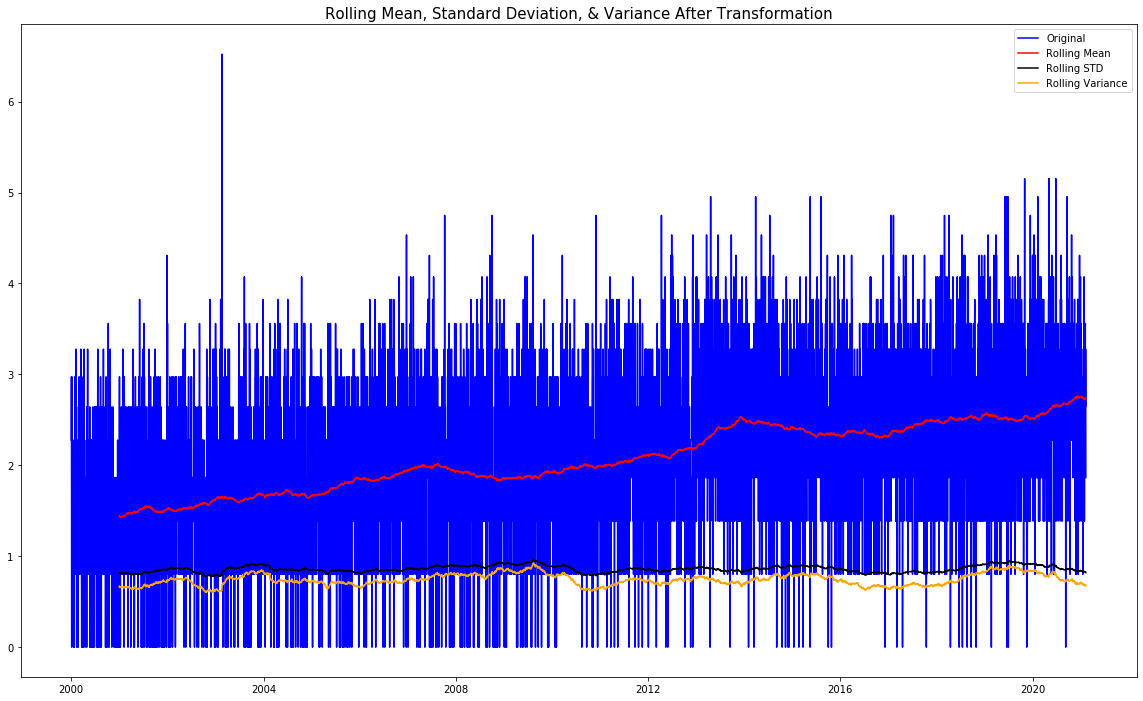

Results of Dickey-Fuller Test:
Test Statistic                     -4.957380
p-value                             0.000027
#Lags Used                         36.000000
Number of Oberservations Used    7673.000000
Critical Value (1%)                -3.431203
Critical Value (5%)                -2.861917
Critical Value (10%)               -2.566971
dtype: float64


,count
count,7710.000000
mean,2.079719
std,0.934765
min,0.000000
25%,1.386813
50%,2.276974
75%,2.642467
max,6.522603


In [154]:
test_stationarity(box1p_national, 'Rolling Mean, Standard Deviation, & Variance After Transformation')
box1p_national.describe()

The orginal dataset is more stationary than the boxcox transformation, but the transformed set is more normal and lends better to modeling/forecasting.

In [19]:
X, y = date_features(box1p_national, label='count')
df_national_time = pd.concat([X, y], axis=1)

### Modeling - Presentation

In [20]:
model_df = pd.DataFrame({'ds' : df_national_time.index,
                         'y' : df_national_time['count']})

In [21]:
last_date = box1p_national.index.max()
start_date = last_date - timedelta(days=121)
mask1 = ((model_df['ds']<start_date) & (model_df['ds'] < last_date))

In [22]:
X_train = model_df.loc[mask1]
X_test = model_df.loc[-mask1]
print("Train Shape :", X_train.shape)
print("Test Shape :", X_test.shape)

Train Shape : (7588, 2)
Test Shape : (122, 2)


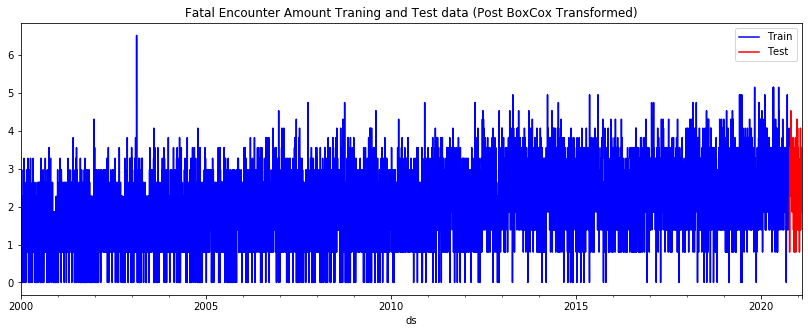

In [23]:
# plot to show how much of the data is used to train and how much is used to test
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
X_train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
X_test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title('Fatal Encounter Amount Traning and Test data (Post BoxCox Transformed)')
plt.show()

### Model - Parameter Grid

In [24]:
params_grid = {'seasonality_mode': ('multiplicative','additive'),
               'changepoint_prior_scale': [0.001, 0.01, 0.1], #0.001
               'changepoint_range': [0.8, 0.9], #0.9
               'seasonality_prior_scale': [0.001, 0.01, 0.1], #0.001
               'holidays_prior_scale': [0.1, 0.3, 0.5], #0.3
               'n_changepoints' : [75, 125], #75
               'uncertainty_samples' : [1000, 1250]} #1500
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 432


### Prophet Model Tuning 

In [25]:
t0 = time.time()

model_parameters = pd.DataFrame(columns = ['MAE', 'Parameters'])
count = 0
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                          n_changepoints = p['n_changepoints'],
                          seasonality_mode = p['seasonality_mode'],
                          seasonality_prior_scale = p['seasonality_prior_scale'],
                          changepoint_range = p['changepoint_range'],
                          holidays_prior_scale = p['holidays_prior_scale'])
    train_model.add_country_holidays(country_name = 'US')
    train_model.fit(X_train)
    train_forecast = train_model.make_future_dataframe(periods=121, freq='D', include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test = train_forecast[['ds', 'yhat']]
    Actual = model_df[(model_df['ds']>start_date) & (model_df['ds']<=last_date)]
    MAE = round(mae(Actual['y'],test['yhat']), 6)
    count += 1
    print('model number :', count, 'MAE :', MAE)
    print('-'*100)
    model_parameters = model_parameters.append({'MAE':MAE, 'Parameters' :p}, ignore_index=True)
    
t1 = time.time()
total = t1-t0
print(total)

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 1 MAE : 0.647186
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 2 MAE : 0.647186
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 3 MAE : 0.672821
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 4 MAE : 0.672821
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 5 MAE : 0.687066
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 6 MAE : 0.687066
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 7 MAE : 0.649876
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 8 MAE : 0.649876
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 9 MAE : 0.665827
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 10 MAE : 0.665827
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 11 MAE : 0.66812
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 12 MAE : 0.66812
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 13 MAE : 0.64945
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 14 MAE : 0.64945
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 15 MAE : 0.685428
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 16 MAE : 0.685428
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 17 MAE : 0.694032
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 18 MAE : 0.694032
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 19 MAE : 0.649975
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 20 MAE : 0.649975
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 21 MAE : 0.673992
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 22 MAE : 0.673992
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 23 MAE : 0.668832
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 24 MAE : 0.668832
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 25 MAE : 0.647582
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 26 MAE : 0.647582
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 27 MAE : 0.67656
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 28 MAE : 0.67656
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 29 MAE : 0.688093
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 30 MAE : 0.688093
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 31 MAE : 0.649995
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 32 MAE : 0.649995
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 33 MAE : 0.66524
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 34 MAE : 0.66524
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 35 MAE : 0.666554
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 36 MAE : 0.666554
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 37 MAE : 0.649828
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 38 MAE : 0.649828
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 39 MAE : 0.671189
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 40 MAE : 0.671189
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 41 MAE : 0.697243
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 42 MAE : 0.697243
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 43 MAE : 0.650097
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 44 MAE : 0.650097
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 45 MAE : 0.66679
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 46 MAE : 0.66679
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 47 MAE : 0.667923
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 48 MAE : 0.667923
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 49 MAE : 0.647174
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 50 MAE : 0.647174
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 51 MAE : 0.685891
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 52 MAE : 0.685891
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 53 MAE : 0.683725
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 54 MAE : 0.683725
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 55 MAE : 0.650396
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 56 MAE : 0.650396
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 57 MAE : 0.66521
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 58 MAE : 0.66521
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 59 MAE : 0.667401
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 60 MAE : 0.667401
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 61 MAE : 0.6479
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 62 MAE : 0.6479
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 63 MAE : 0.682643
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 64 MAE : 0.682643
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 65 MAE : 0.695843
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 66 MAE : 0.695843
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 67 MAE : 0.649841
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 68 MAE : 0.649841
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 69 MAE : 0.669922
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 70 MAE : 0.669922
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 71 MAE : 0.675229
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 72 MAE : 0.675229
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 73 MAE : 0.646497
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 74 MAE : 0.646497
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 75 MAE : 0.673667
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 76 MAE : 0.673667
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 77 MAE : 0.691227
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 78 MAE : 0.691227
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 79 MAE : 0.650187
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 80 MAE : 0.650187
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 81 MAE : 0.66807
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 82 MAE : 0.66807
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 83 MAE : 0.669466
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 84 MAE : 0.669466
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 85 MAE : 0.64703
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 86 MAE : 0.64703
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 87 MAE : 0.673
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 88 MAE : 0.673
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 89 MAE : 0.694299
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 90 MAE : 0.694299
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 91 MAE : 0.653647
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 92 MAE : 0.653647
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 93 MAE : 0.675603
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 94 MAE : 0.675603
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 95 MAE : 0.680292
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 96 MAE : 0.680292
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 97 MAE : 0.648547
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 98 MAE : 0.648547
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 99 MAE : 0.673122
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 100 MAE : 0.673122
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 101 MAE : 0.691877
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 102 MAE : 0.691877
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 103 MAE : 0.650904
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 104 MAE : 0.650904
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 105 MAE : 0.672165
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 106 MAE : 0.672165
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 107 MAE : 0.667837
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 108 MAE : 0.667837
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 109 MAE : 0.65009
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 110 MAE : 0.65009
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 111 MAE : 0.679292
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 112 MAE : 0.679292
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 113 MAE : 0.691649
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 114 MAE : 0.691649
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 115 MAE : 0.650292
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 116 MAE : 0.650292
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 117 MAE : 0.673271
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 118 MAE : 0.673271
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 119 MAE : 0.675104
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 120 MAE : 0.675104
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 121 MAE : 0.646516
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 122 MAE : 0.646516
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 123 MAE : 0.679403
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 124 MAE : 0.679403
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 125 MAE : 0.693038
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 126 MAE : 0.693038
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 127 MAE : 0.649755
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 128 MAE : 0.649755
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 129 MAE : 0.670847
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 130 MAE : 0.670847
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 131 MAE : 0.669386
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 132 MAE : 0.669386
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 133 MAE : 0.646766
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 134 MAE : 0.646766
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 135 MAE : 0.675712
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 136 MAE : 0.675712
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 137 MAE : 0.6892
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 138 MAE : 0.6892
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 139 MAE : 0.650108
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 140 MAE : 0.650108
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 141 MAE : 0.668881
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 142 MAE : 0.668881
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 143 MAE : 0.682068
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 144 MAE : 0.682068
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 145 MAE : 0.648577
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 146 MAE : 0.648577
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 147 MAE : 0.665259
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 148 MAE : 0.665259
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 149 MAE : 0.675672
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 150 MAE : 0.675672
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 151 MAE : 0.655181
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 152 MAE : 0.655181
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 153 MAE : 0.672608
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 154 MAE : 0.672608
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 155 MAE : 0.674426
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 156 MAE : 0.674426
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 157 MAE : 0.648288
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 158 MAE : 0.648288
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 159 MAE : 0.665656
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 160 MAE : 0.665656
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 161 MAE : 0.675188
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 162 MAE : 0.675188
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 163 MAE : 0.654172
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 164 MAE : 0.654172
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 165 MAE : 0.672479
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 166 MAE : 0.672479
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 167 MAE : 0.673473
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 168 MAE : 0.673473
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 169 MAE : 0.648547
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 170 MAE : 0.648547
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 171 MAE : 0.665524
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 172 MAE : 0.665524
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 173 MAE : 0.677085
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 174 MAE : 0.677085
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 175 MAE : 0.654865
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 176 MAE : 0.654865
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 177 MAE : 0.673295
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 178 MAE : 0.673295
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 179 MAE : 0.674562
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 180 MAE : 0.674562
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 181 MAE : 0.648382
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 182 MAE : 0.648382
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 183 MAE : 0.664732
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 184 MAE : 0.664732
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 185 MAE : 0.67712
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 186 MAE : 0.67712
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 187 MAE : 0.655775
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 188 MAE : 0.655775
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 189 MAE : 0.672169
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 190 MAE : 0.672169
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 191 MAE : 0.675197
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 192 MAE : 0.675197
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 193 MAE : 0.648567
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 194 MAE : 0.648567
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 195 MAE : 0.665451
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 196 MAE : 0.665451
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 197 MAE : 0.675643
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 198 MAE : 0.675643
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 199 MAE : 0.654666
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 200 MAE : 0.654666
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 201 MAE : 0.672996
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 202 MAE : 0.672996
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 203 MAE : 0.673931
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 204 MAE : 0.673931
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 205 MAE : 0.648509
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 206 MAE : 0.648509
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 207 MAE : 0.665001
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 208 MAE : 0.665001
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 209 MAE : 0.676372
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 210 MAE : 0.676372
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 211 MAE : 0.655378
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 212 MAE : 0.655378
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 213 MAE : 0.672401
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 214 MAE : 0.672401
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 215 MAE : 0.674927
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 216 MAE : 0.674927
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 217 MAE : 0.648578
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 218 MAE : 0.648578
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 219 MAE : 0.66479
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 220 MAE : 0.66479
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 221 MAE : 0.676582
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 222 MAE : 0.676582
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 223 MAE : 0.654766
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 224 MAE : 0.654766
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 225 MAE : 0.672358
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 226 MAE : 0.672358
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 227 MAE : 0.673108
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 228 MAE : 0.673108
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 229 MAE : 0.648682
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 230 MAE : 0.648682
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 231 MAE : 0.664965
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 232 MAE : 0.664965
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 233 MAE : 0.675513
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 234 MAE : 0.675513
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 235 MAE : 0.655033
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 236 MAE : 0.655033
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 237 MAE : 0.672785
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 238 MAE : 0.672785
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 239 MAE : 0.673792
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 240 MAE : 0.673792
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 241 MAE : 0.648386
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 242 MAE : 0.648386
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 243 MAE : 0.665483
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 244 MAE : 0.665483
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 245 MAE : 0.675883
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 246 MAE : 0.675883
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 247 MAE : 0.655027
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 248 MAE : 0.655027
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 249 MAE : 0.672734
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 250 MAE : 0.672734
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 251 MAE : 0.673566
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 252 MAE : 0.673566
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 253 MAE : 0.648727
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 254 MAE : 0.648727
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 255 MAE : 0.665499
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 256 MAE : 0.665499
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 257 MAE : 0.675188
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 258 MAE : 0.675188
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 259 MAE : 0.655289
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 260 MAE : 0.655289
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 261 MAE : 0.673216
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 262 MAE : 0.673216
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 263 MAE : 0.674341
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 264 MAE : 0.674341
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 265 MAE : 0.648487
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 266 MAE : 0.648487
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 267 MAE : 0.664637
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 268 MAE : 0.664637
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 269 MAE : 0.676859
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 270 MAE : 0.676859
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 271 MAE : 0.655347
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 272 MAE : 0.655347
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 273 MAE : 0.672084
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 274 MAE : 0.672084
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 275 MAE : 0.674165
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 276 MAE : 0.674165
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 277 MAE : 0.648412
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 278 MAE : 0.648412
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 279 MAE : 0.664699
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 280 MAE : 0.664699
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 281 MAE : 0.675694
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 282 MAE : 0.675694
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 283 MAE : 0.655875
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 284 MAE : 0.655875
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 285 MAE : 0.67327
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 286 MAE : 0.67327
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 287 MAE : 0.674179
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 288 MAE : 0.674179
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 289 MAE : 0.652214
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 290 MAE : 0.652214
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 291 MAE : 0.669911
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 292 MAE : 0.669911
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 293 MAE : 0.68154
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 294 MAE : 0.68154
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 295 MAE : 0.655308
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 296 MAE : 0.655308
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 297 MAE : 0.674129
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 298 MAE : 0.674129
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 299 MAE : 0.675828
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 300 MAE : 0.675828
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 301 MAE : 0.652201
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 302 MAE : 0.652201
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 303 MAE : 0.66989
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 304 MAE : 0.66989
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 305 MAE : 0.681702
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 306 MAE : 0.681702
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 307 MAE : 0.65525
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 308 MAE : 0.65525
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 309 MAE : 0.674199
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 310 MAE : 0.674199
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 311 MAE : 0.675583
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 312 MAE : 0.675583
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 313 MAE : 0.655496
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 314 MAE : 0.655496
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 315 MAE : 0.672385
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 316 MAE : 0.672385
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 317 MAE : 0.683917
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 318 MAE : 0.683917
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 319 MAE : 0.65578
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 320 MAE : 0.65578
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 321 MAE : 0.674899
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 322 MAE : 0.674899
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 323 MAE : 0.675791
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 324 MAE : 0.675791
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 325 MAE : 0.654957
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 326 MAE : 0.654957
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 327 MAE : 0.67209
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 328 MAE : 0.67209
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 329 MAE : 0.683436
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 330 MAE : 0.683436
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 331 MAE : 0.655791
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 332 MAE : 0.655791
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 333 MAE : 0.67456
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 334 MAE : 0.67456
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 335 MAE : 0.676087
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 336 MAE : 0.676087
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 337 MAE : 0.655579
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 338 MAE : 0.655579
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 339 MAE : 0.672761
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 340 MAE : 0.672761
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 341 MAE : 0.683859
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 342 MAE : 0.683859
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 343 MAE : 0.655804
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 344 MAE : 0.655804
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 345 MAE : 0.674902
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 346 MAE : 0.674902
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 347 MAE : 0.67601
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 348 MAE : 0.67601
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 349 MAE : 0.655624
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 350 MAE : 0.655624
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 351 MAE : 0.672783
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 352 MAE : 0.672783
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 353 MAE : 0.684338
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 354 MAE : 0.684338
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 355 MAE : 0.655794
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 356 MAE : 0.655794
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 357 MAE : 0.674855
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 358 MAE : 0.674855
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 359 MAE : 0.675918
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 360 MAE : 0.675918
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 361 MAE : 0.652108
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 362 MAE : 0.652108
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 363 MAE : 0.669643
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 364 MAE : 0.669643
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 365 MAE : 0.681228
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 366 MAE : 0.681228
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 367 MAE : 0.655249
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 368 MAE : 0.655249
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 369 MAE : 0.674274
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 370 MAE : 0.674274
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 371 MAE : 0.675233
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 372 MAE : 0.675233
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 373 MAE : 0.6522
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 374 MAE : 0.6522
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 375 MAE : 0.669638
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 376 MAE : 0.669638
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 377 MAE : 0.681402
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 378 MAE : 0.681402
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 379 MAE : 0.655308
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 380 MAE : 0.655308
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 381 MAE : 0.673894
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 382 MAE : 0.673894
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 383 MAE : 0.675494
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 384 MAE : 0.675494
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 385 MAE : 0.655299
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 386 MAE : 0.655299
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 387 MAE : 0.67248
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 388 MAE : 0.67248
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 389 MAE : 0.683948
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 390 MAE : 0.683948
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 391 MAE : 0.655815
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 392 MAE : 0.655815
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 393 MAE : 0.674553
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 394 MAE : 0.674553
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 395 MAE : 0.676021
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 396 MAE : 0.676021
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 397 MAE : 0.655064
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 398 MAE : 0.655064
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 399 MAE : 0.672771
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 400 MAE : 0.672771
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 401 MAE : 0.683864
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 402 MAE : 0.683864
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 403 MAE : 0.655745
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 404 MAE : 0.655745
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 405 MAE : 0.674703
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 406 MAE : 0.674703
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 407 MAE : 0.67588
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 408 MAE : 0.67588
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 409 MAE : 0.655657
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 410 MAE : 0.655657
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 411 MAE : 0.672819
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 412 MAE : 0.672819
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 413 MAE : 0.68454
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 414 MAE : 0.68454
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 415 MAE : 0.65581
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 416 MAE : 0.65581
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 417 MAE : 0.674519
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 418 MAE : 0.674519
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 419 MAE : 0.67605
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 75, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 420 MAE : 0.67605
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 421 MAE : 0.655479
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 422 MAE : 0.655479
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 423 MAE : 0.672984
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 424 MAE : 0.672984
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 425 MAE : 0.683941
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 426 MAE : 0.683941
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 427 MAE : 0.65577
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 428 MAE : 0.65577
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 429 MAE : 0.67474
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'uncertainty_samples': 1250}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 430 MAE : 0.67474
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1000}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 431 MAE : 0.676126
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'n_changepoints': 125, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1, 'uncertainty_samples': 1250}
model number : 432 MAE : 0.676126
----------------------------------------------------------------------------------------------------
7308.221949338913


Best model parameters are:

In [26]:
# Best Parameters are being selected and being ran again one last time for te final model
parameters = model_parameters.sort_values(by=['MAE'])
parameters = parameters.reset_index(drop=True)
print(parameters['Parameters'][0])
params = parameters['Parameters'][0]
final_model = Prophet(**params, daily_seasonality=False)
final_model.add_country_holidays(country_name='US')
final_model.fit(X_train)
future = final_model.make_future_dataframe(periods=171, freq='D')
forecast = final_model.predict(future)

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'n_changepoints': 75, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001, 'uncertainty_samples': 1000}


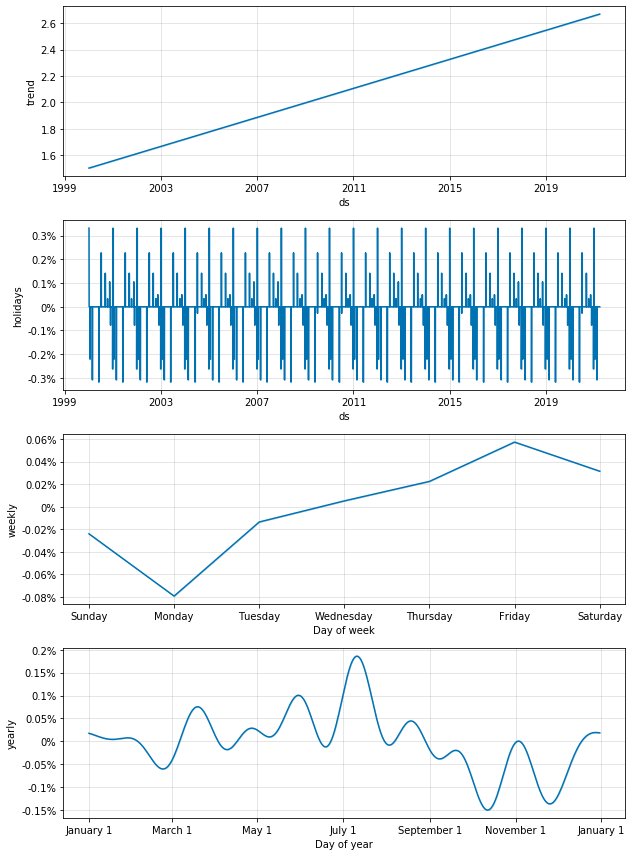

In [27]:
# Plot the components of the model
fig = final_model.plot_components(forecast)

In [28]:
# All scoring will be done after reverting the Fatal Encounter variable back to its pre-boxcox transformation form
forecast['yhat'] = inv_boxcox1p(forecast['yhat'], lam)
forecast['yhat_lower'] = inv_boxcox1p(forecast['yhat_lower'], lam)
forecast['yhat_upper'] = inv_boxcox1p(forecast['yhat_upper'], lam)
forecast.index = forecast['ds']

In [32]:
# Plot of Actual Fatal Encounters, Prediction from the model, Lower, and Upper yhat predictions
fig = go.Figure([
    go.Scatter(
        name='Prediction',
        x=forecast.index[-182:],
        y=forecast['yhat'],
        mode='lines',
        line=dict(color='rgb(255, 140, 0)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=forecast.index[-182:],
        y=forecast['yhat']+forecast['yhat_upper'],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=forecast.index[-182:],
        y=forecast['yhat']-forecast['yhat_lower'],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    ),
    go.Scatter(
        name='Actual',
        x=forecast.index,
        y=national['count'],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )])

fig.update_layout(
    yaxis_title='Count of Fatal Encounters',
    title='Continuous, variable value error bars',
    hovermode="x")

fig.update_xaxes(rangeslider_visible=True)
fig.write_html('first_figure.html', auto_open=True)

In [31]:
# In order to test results, we need to revert X_test to its previous boxcox transformation form
inv_X_test = inv_boxcox1p(X_test['y'], lam)
# Need to create index mask to pass in consistent input variables into MAE scoring 
    # The need comes from the forecast going past observable results therefore we need to omit those forecasts when scoring the model
index_mask = inv_X_test.index
print("MAE",round(mae(inv_X_test,forecast.loc[index_mask]['yhat']),6))

MAE 1.87819


### Boxcox Inverted Final Model and Results

In [91]:
# # Setup & Train Model w/ Holidays (replace with personal code)

# final_model = Prophet(holidays = holiday,
#                       changepoint_prior_scale = 0.001,
#                       holidays_prior_scale = 0.3,
#                       changepoint_range = 0.8,
#                       n_changepoints = 75,
#                       seasonality_mode = 'multiplicative',
#                       seasonality_prior_scale = 0.001,
#                       uncertainty_samples = 1000,
#                       interval_width = 0.6,
#                       weekly_seasonality=True,
#                       daily_seasonality = True,
#                       yearly_seasonality = True)
# final_model.add_country_holidays(country_name='US')
# final_model.fit(X_train)

In [90]:
# inv_X_test = inv_boxcox1p(X_test['y'], lam)

In [89]:
# inv_X_test_final = inv_boxcox1p(X_test_final['yhat'], lam)

In [88]:
# inv_X_test_final.index = inv_X_test.index

In [87]:
# # Plot the components of the model
# fig = final_model.plot_components(forecast)

In [85]:
# # Plot the forecast
# f, ax = plt.subplots(1)
# f.set_figheight(5)
# f.set_figwidth(15)
# fig = final_model.plot(forecast,ax=ax)
# plt.show()

In [86]:
# f, ax = plt.subplots(figsize=(14,5))
# f.set_figheight(5)
# f.set_figwidth(15)
# inv_X_test.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
# inv_X_test_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
# plt.title('Forecast vs Actuals')
# plt.show()

In [218]:
# print("MAE",round(mae(inv_X_test,inv_X_test_final),6))

MAE 1.899654


### I'm not really sure why this is here - _ -

Text(0.5, 1.0, 'Histogram of Fatal Encounters Since Jan 1, 2000 (Boxcox1p lamda = [0.40814021])')

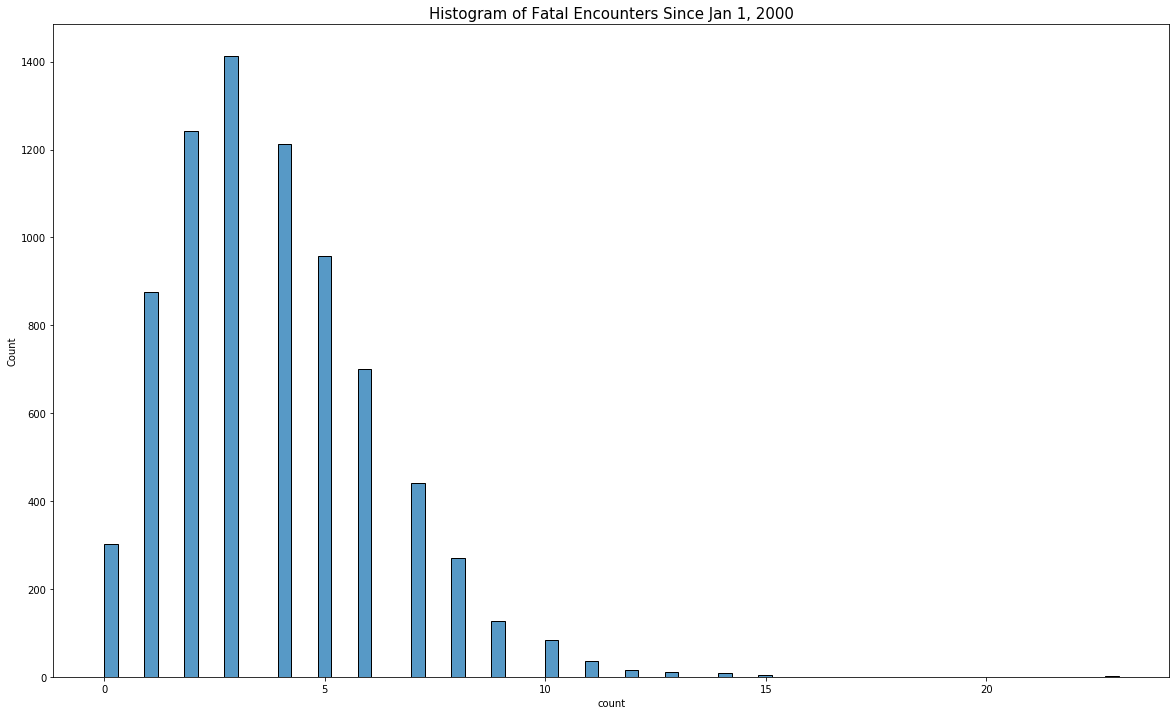

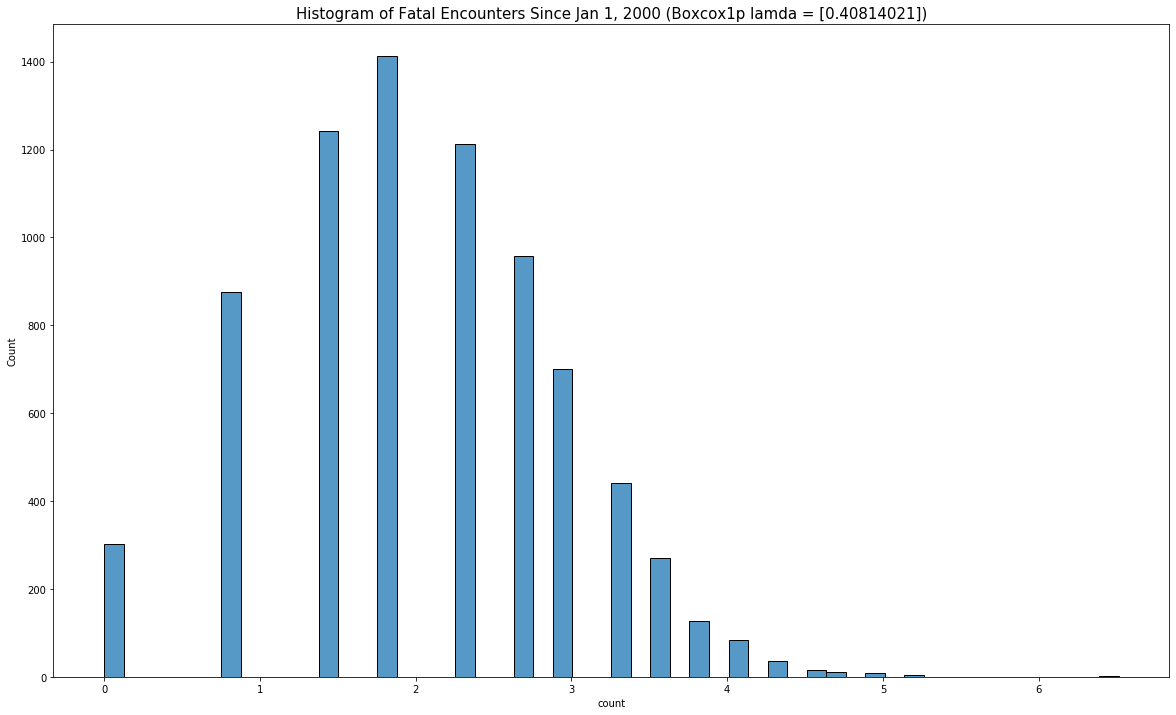

In [78]:
# method 'yeo-johnson' is selected bcuz the data contains non-positive numbers i.e 0
pt = PowerTransformer(method='yeo-johnson')
pt.fit(national)
lam = pt.lambdas_

box1p_national = boxcox1p(national, lam)

fig, ax = plt.subplots(figsize=(20,12))
a = sns.histplot(data=national, x="count")
a.set_title("Histogram of Fatal Encounters Since Jan 1, 2000", fontsize=15)

fig, ax = plt.subplots(figsize=(20,12))
a = sns.histplot(data=box1p_national, x="count")
a.set_title("Histogram of Fatal Encounters Since Jan 1, 2000 (Boxcox1p lamda = {})".format(lam), fontsize=15)

# Product development Break

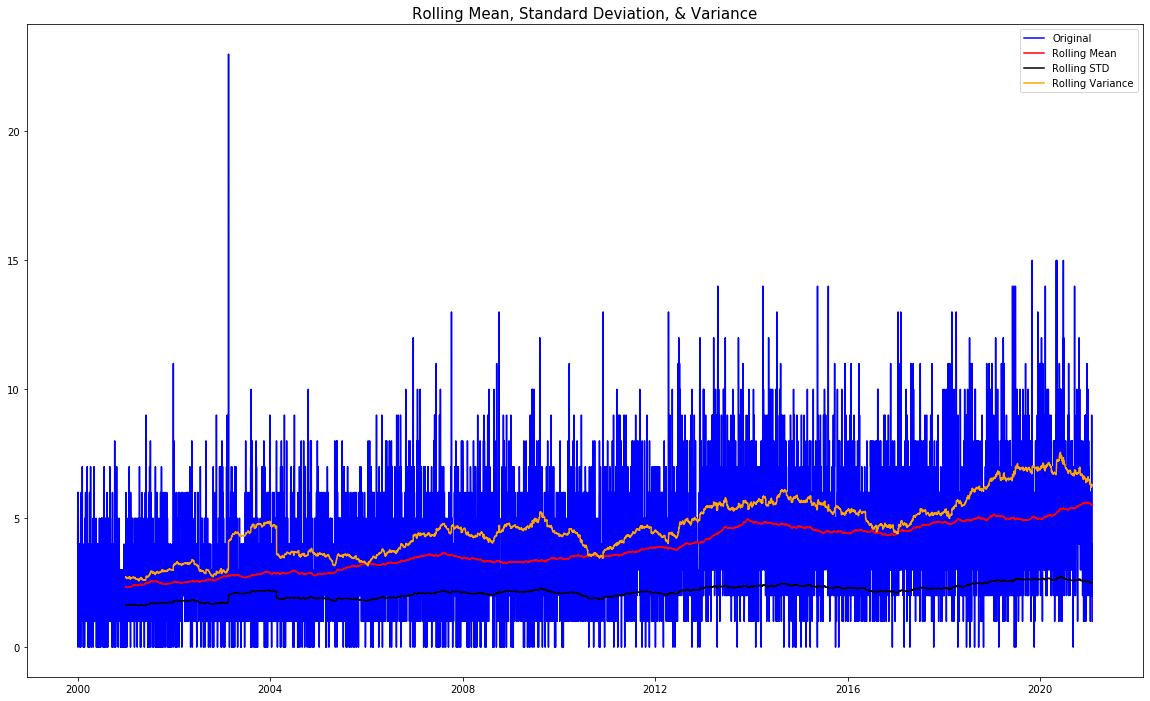

Results of Dickey-Fuller Test:
Test Statistic                     -5.199966
p-value                             0.000009
#Lags Used                         36.000000
Number of Oberservations Used    7664.000000
Critical Value (1%)                -3.431204
Critical Value (5%)                -2.861917
Critical Value (10%)               -2.566971
dtype: float64
             count
count  7701.000000
mean      3.839761
std       2.346156
min       0.000000
25%       2.000000
50%       4.000000
75%       5.000000
max      23.000000


In [81]:
test_stationarity(national)
print(national.describe())

### The Product

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams['figure.figsize'] = 20, 12
import itertools 
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric as pcvm
from scipy.special import inv_boxcox1p, boxcox1p
from scipy.stats import normaltest
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.stattools import adfuller
import datetime
from urllib.parse import quote
import holidays
import random

Import, Transform, Creating, and Reading Datasets as a Time Series

In [39]:
# Importing Dataset
gsheetid = r'1dKmaV_JiWcG8XBoRgP8b4e9Eopkpgt7FL7nyspvzAsE'
sheet_name = quote('Form Responses', safe='')
gsheet_url = r"https://docs.google.com/spreadsheets/d/{}/gviz/tq?tqx=out:csv&sheet={}".format(gsheetid, sheet_name)
df = pd.read_csv(gsheet_url)

C:\Users\latee\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (15,20,21,22,23,24,25,26,37,39,40,41,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.



In [40]:
# Transforming Dataset
    #  Casting columns in lowercase
df.columns = map(lambda x: x.lower(), df.columns)

    # Casting new column names
df = df.rename(columns={"subject's race":"race", 'location of death (city)' : 'city',
                        'location of death (county)' : 'county', 'location of death (zip code)':'zipcode',
                        "date of injury resulting in death (month/day/year)":"date"})

    # Filling in missing data points in observations with values that doesn't obscure data
df = df.fillna(value={'race':'unspecified', 'location of death (city)':'unspecified',
                      'location of death (county)':'unspecified'})

In [41]:
# Creating National Time Series Dataframe 
ld = list(df.date)
ld1 = pd.to_datetime(ld)
ld2 = pd.Series(ld1.to_period('d'))
ts = ld2.value_counts().sort_index().reset_index()
ts.columns = ['date', 'count']
ts.date = ts.date.dt.strftime('%m-%d-%Y')
ts.index = pd.to_datetime(ts.date)
tss = ts.drop('date', axis=1)
# this had to be a added to drop the invalid date they have in their google sheet as a spacer
tsss = tss[:-1]
all_dates = pd.date_range(start='2000/01/01', end=tsss.index.max(), freq='D')
national = tsss.reindex(all_dates, fill_value=0)

In [150]:
def test_stationarity(timeseries, title):
    
    # Determining Rolling Statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    rolvar = timeseries.rolling(window=365).var()
    
    # Plot Rolling Statistics
    fig, ax = plt.subplots(figsize=(20,12))
    a = plt.plot(timeseries, color='blue', label='Original')
    a = plt.plot(rolmean, color='red', label='Rolling Mean')
    a = plt.plot(rolstd, color='black', label='Rolling STD')
    a = plt.plot(rolvar, color='orange', label='Rolling Variance')
    a = plt.legend(loc='best')
    ax.set_title(title, fontsize=15)
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[:4], index=['Test Statistic', 'p-value', '#Lags Used',
                                            'Number of Oberservations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [168]:
def sci_plots(df, response1):  
    
    # Plotting histogram of orginal dataset
    fig, ax = plt.subplots(figsize=(20,12))
    a = sns.histplot(data=df, x="count")
    a.set_title("Histogram of Fatal Encounters Since Jan 1, 2000 Orginal Dataset", fontsize=15)
    
    stat, p_ = normaltest(df)
    
    print('Test Statistic of National Before Transform:', stat)
    print('p_value of National Before Transform:', p_)
    print()
    
    # method 'yeo-johnson' is selected bcuz the data contains non-positive numbers i.e 0
    # PowerTransformer is used to find the best boxcox lambda to transform the dataset passed in, into one with "normal" properties
    pt = PowerTransformer(method='yeo-johnson')
    pt.fit(df)
    lam = pt.lambdas_
    
    box1p_df = boxcox1p(df, lam)
    stat, p_ = normaltest(box1p_df)
    
    fig, ax = plt.subplots(figsize=(20,12))
    a = sns.histplot(data=box1p_df, x="count")
    a.set_title("Histogram of Fatal Encounters Since Jan 1, 2000 After Transformation (Boxcox1p lambda: {})".format(lam), fontsize=15)
    
    print('Test Statistic of {} After Transform:'.format(response1), stat)
    print('p_value of {} After Transform:'.format(response1), p_)
    print()
    
    test_stationarity(df, 'Rolling Mean, Standard Deviation, & Variance of Orginal')
    print('Orginal','\n', df.describe(), '\n')
    test_stationarity(box1p_df, 'Rolling Mean, Standard Deviation, & Variance After Transformation')
    print('Transformed','\n', box1p_df.describe(), '\n')
    
    return

In [163]:
# Function to display graphics for an overview of incidents
def display_ts_plots(df, response1):
    X, y = date_features(df, label='count')
    data = pd.concat([X, y], axis=1)
        
    # Total Count of Fatal Encouters
    fig, ax = plt.subplots(figsize=(20,12))
    yearaggregated = pd.DataFrame(data.groupby("year")["count"].sum()).reset_index()
    a = sns.barplot(data=yearaggregated, x="year", y="count")
    a.set_title("Total {} of Fatal Encounters per Year".format(response1), fontsize=15)
    
    # Display Plots
        # A bar plot represents an estimate of central tendency for a numeric variable with the height of each rectangle and 
        # Provides some indication of the uncertainty around that estimate using error bars.
    fig, ax = plt.subplots(figsize=(20,12))
    a = sns.barplot(x= "year", y= "count", hue = 'quarter', data = data)
    a.set_title("Central Tendency of {} Fatal Encounters by Year per Quarter of the Year".format(response1), fontsize=15)
    plt.legend(loc='best', prop={'size': 12})
    
    fig, ax = plt.subplots(figsize=(20,12))
    a = sns.barplot(x= "year", y= "count", hue = 'dayofweek', data = data)
    a.set_title("Central Tendency of {} of Fatal Encounters by Year per Day of the Week".format(response1), fontsize=15)
    plt.legend(loc='best', prop={'size': 12})
    plt.show()

In [141]:
# Function to create dataframe that breaks up the different aspects of dates of fatal encounters out into columns
def date_features(df, label=None):
    df = df.copy()
    
    df['date'] = df.index
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime("%A")
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    return X

In [156]:
def ask_inputs():
    
    response = input("Are you interested in the US National, State, City, County, or Zipcode report of Fatal Encounters?")
    response = response.lower().replace(" ", "")
    
    if response == 'usnational':
        print('Ok National Report, please wait while reports are being generated.')
        response1 = 'United States'
        display_ts_plots(national, response1)

        print("Scientific plots include 2 histograms one before and one after boxcox transformation, a stationarity test, and other measures informing the user of central tendency of the dataset.")
        s_plots = input('Would you like to see the scientific plots of the national fatal encounters dataset before moving forward or would you like to skip ahead to just seeing the fatal encounters and forecast?').lower().replace(" ", "")
        
        if s_plots == 'yes':
            print()
            print()
            sci_plots(national, response1)
            
        else:
            pass
        
    elif response == 'state':
        print('Ok State Report, please wait while reports are being generated.')
        states = output_ts_dict(df, 'state')
        def state_option(states):
            response1 = input('Which state are you interested in receiving a report about?')
            response1 = response1.upper()
            try:
                display_ts_plots(states[response1], response1)
            except KeyError:
                print('Invalid Response: Please Enter a valid state.')
                state_option(states)
        state_option(states)
    
    
    elif response == 'city':
        print('Ok City Report, please wait while reports are being generated.')
        cities = output_ts_dict(df, 'city')
        def city_option(cities):
            response1 = input('Which city are you interested in receiving a report about?')
            response1 = response1.title()
            try:
                display_ts_plots(cities[response1], response1)
            except KeyError:
                print("Sorry, unfortunately I couldn't find that {} not all {} are in the system.".format("city", "cities"))
                print("Please try another city")
                city_option(cities)
        city_option(cities)
    
    
    elif response == 'county':
        print('Ok County Report, please wait while reports are being generated.')
        counties = output_ts_dict(df, 'county')
        def county_option(counties):
            response1 = input('Which county are you interested in receiving a report about?')
            response1 = response1.title()
            try:
                display_ts_plots(counties[response1], response1)
            except KeyError:
                print("Sorry, unfortunately I couldn't find that {} not all {} are in the system.".format("county", "counties"))
                print("Please try another county")
                county_option(counties)
        county_option(counties)
    
    
    elif response == 'zipcode':
        print('Ok Zipcode Report, please wait while reports are being generated.')
        zipcodes = output_ts_dict(df, 'zipcode')
        def zipcode_option(zipcodes):
            response1 = input('Which zipcode are you interested in receiving a report about?')
            response1 = float(response1)
            try:
                display_ts_plots(zipcodes[response1], response1)
            except KeyError:
                print("Sorry, unfortunately I couldn't find that {} not all {} are in the system.".format("zipcode", "zipcodes"))
                print("Please try another zipcode")
                zipcode_option(zipcodes)
        zipcode_option(zipcodes)
    
    
    else:
        print('The response options are US National, State, City, County, Zipcode?')
        ask_inputs()
        return
    return

Are you interested in the US National, State, City, County, or Zipcode report of Fatal Encounters? usnational


Ok National Report, please wait while reports are being generated.


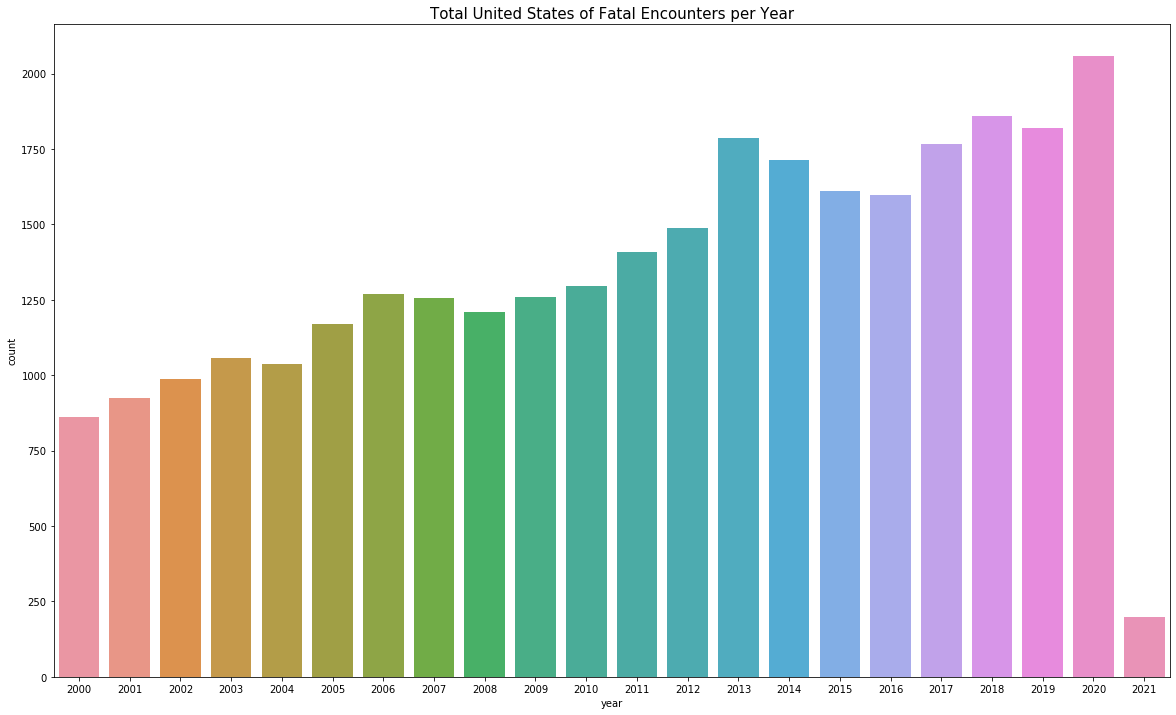

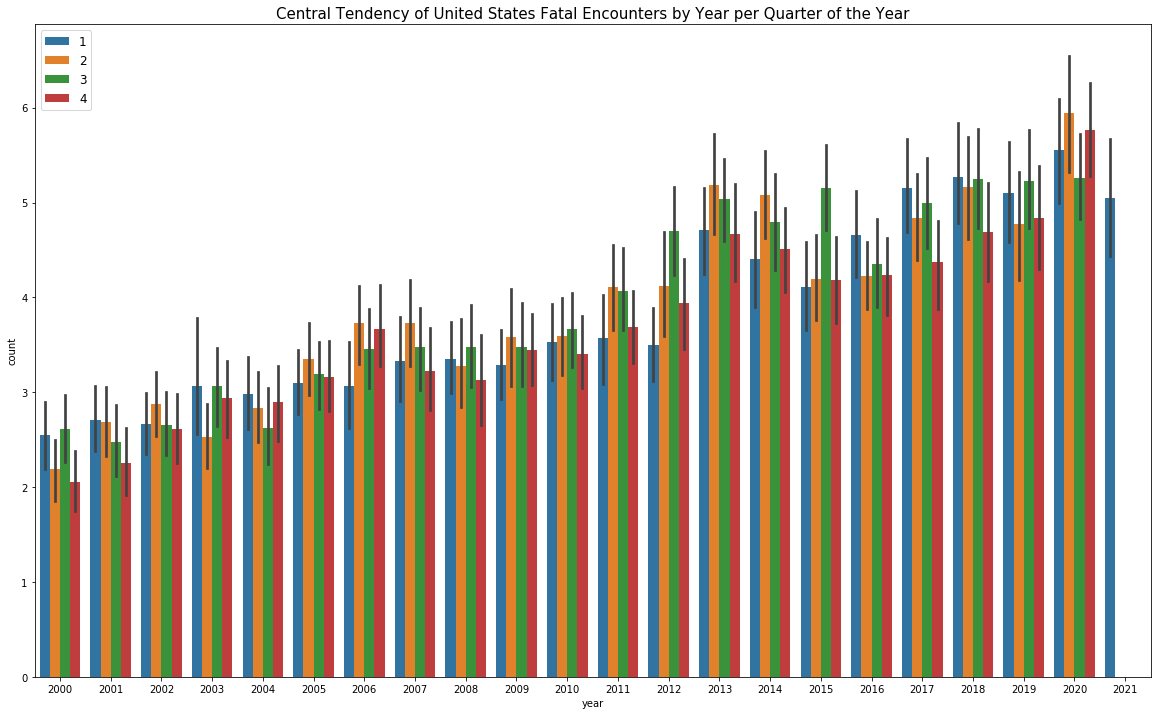

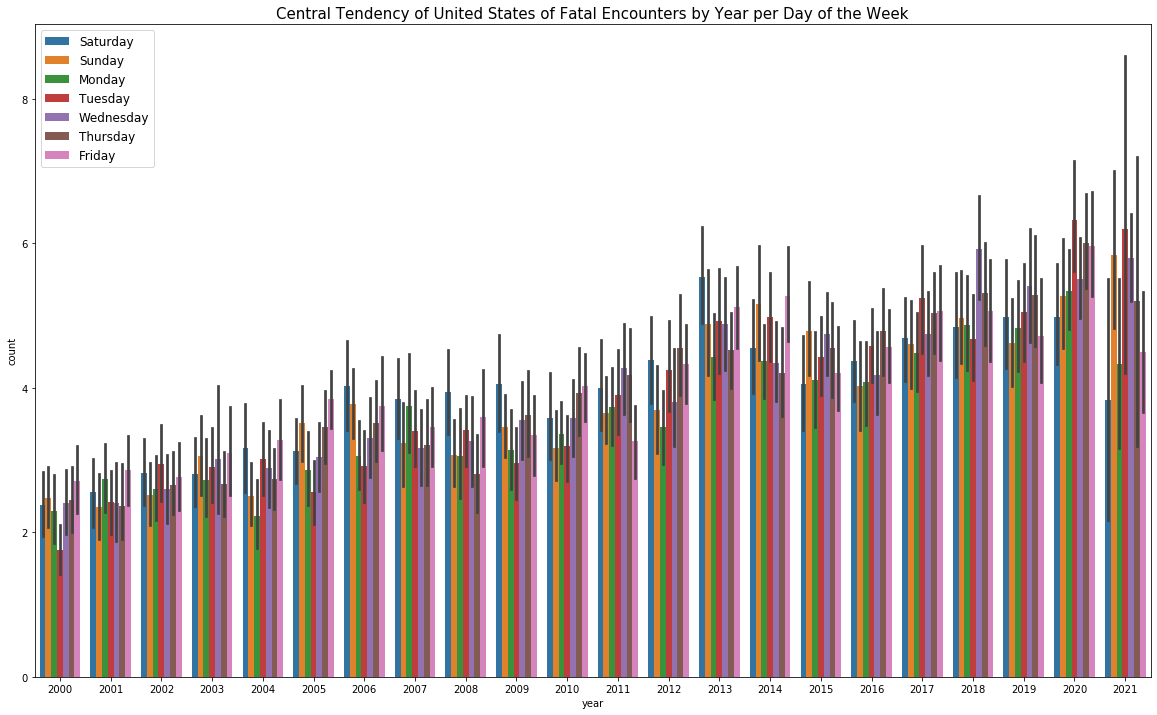

Scientific plots include 2 histograms one before and one after boxcox transformation, a stationarity test, and other measures informing the user of central tendency of the dataset.


Would you like to see the scientific plots of the national fatal encounters dataset before moving forward or would you like to skip ahead to just seeing the fatal encounters and forecast? yes




Test Statistic of National Before Transform: [918.81440955]
p_value of National Before Transform: [3.03379352e-200]

Test Statistic of United States After Transform: [7.08190769]
p_value of United States After Transform: [0.02898567]



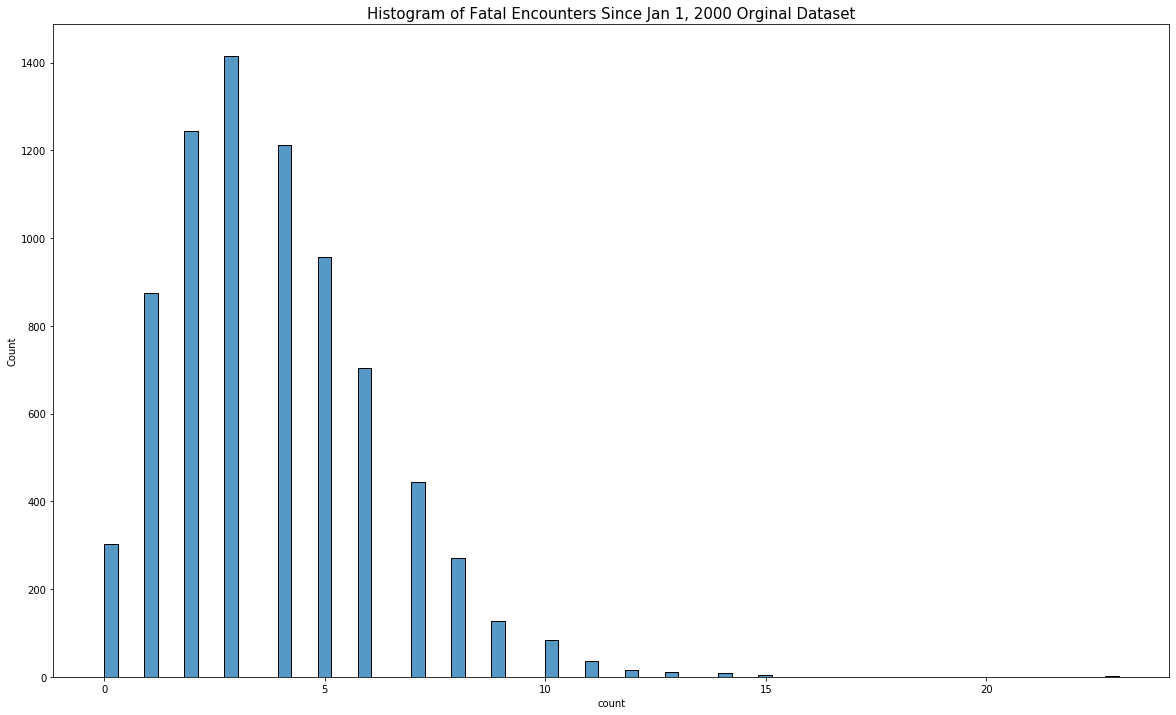

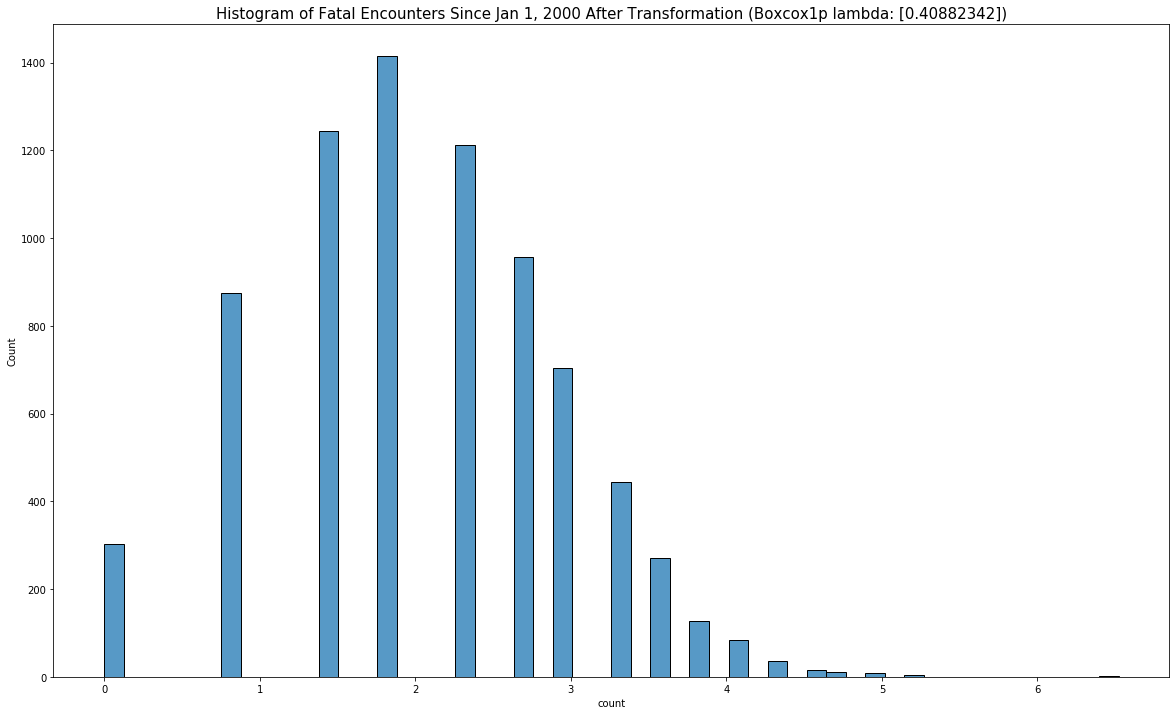

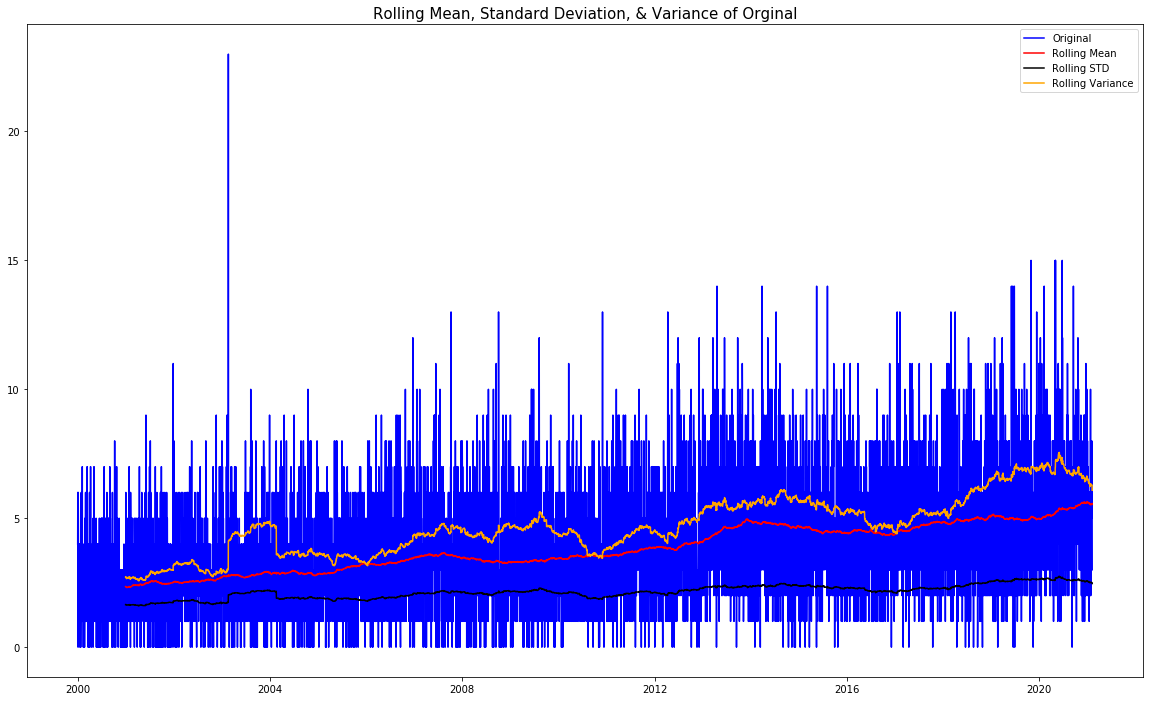

Results of Dickey-Fuller Test:
Test Statistic                     -5.115647
p-value                             0.000013
#Lags Used                         36.000000
Number of Oberservations Used    7673.000000
Critical Value (1%)                -3.431203
Critical Value (5%)                -2.861917
Critical Value (10%)               -2.566971
dtype: float64
Orginal 
              count
count  7710.000000
mean      3.843320
std       2.347343
min       0.000000
25%       2.000000
50%       4.000000
75%       5.000000
max      23.000000 



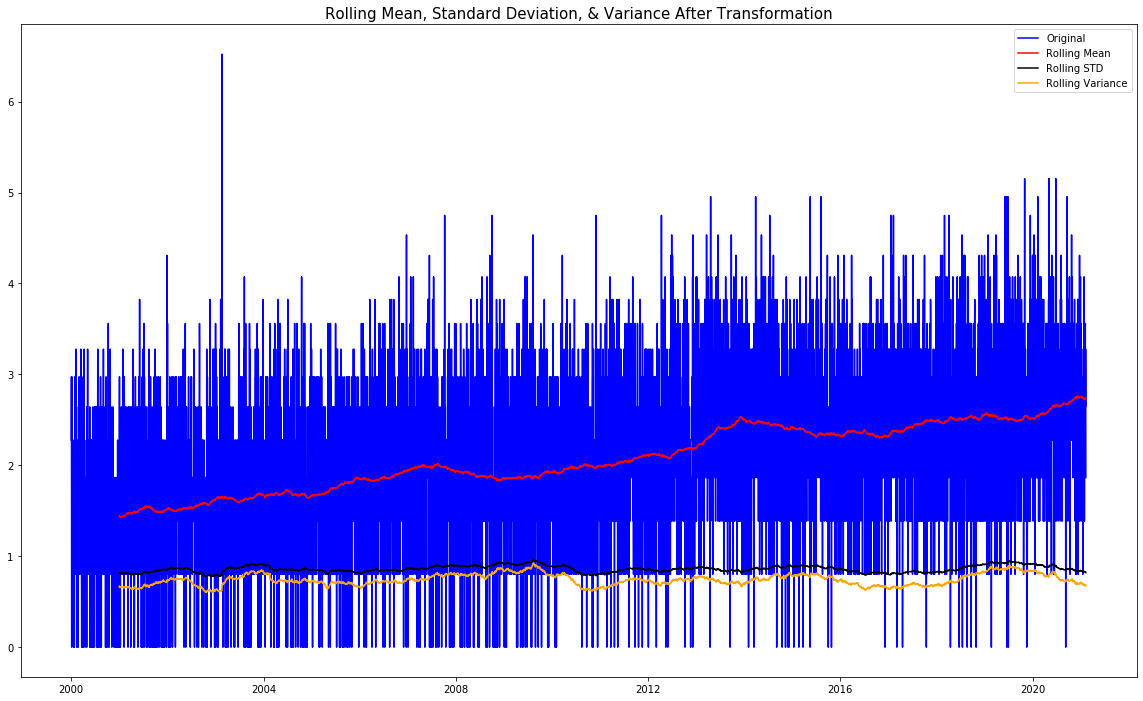

Results of Dickey-Fuller Test:
Test Statistic                     -4.957380
p-value                             0.000027
#Lags Used                         36.000000
Number of Oberservations Used    7673.000000
Critical Value (1%)                -3.431203
Critical Value (5%)                -2.861917
Critical Value (10%)               -2.566971
dtype: float64
Transformed 
              count
count  7710.000000
mean      2.079719
std       0.934765
min       0.000000
25%       1.386813
50%       2.276974
75%       2.642467
max       6.522603 



In [169]:
ask_inputs()